In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.timeseries import LombScargle
from numpy.random import permutation
from scipy.interpolate import interp1d
%matplotlib inline

In [10]:
def ls(time,flux,osample=10):
    '''Lomb Scargle periodogram

    Returns periodogram in units of muHz and amplitude
    '''
    time = np.copy(time)
    flux = np.copy(flux)
    osample = float(osample)
    time-=time[0]
    c=np.median(np.diff(time))

    #if in days, convert to seconds
    if c < 1:
        time*=86400.
        c*=86400.

    nyq=1./(2.*c)
    df=(1./time[-1])

    f = np.arange(df,nyq,df/osample)

    ls=LombScargle(time,flux)
    p =  ls.power(f,normalization='psd')
    f = 1.e+6 * f # put f in micro Hz

    return f,np.sqrt(p*4./time.size)

In [11]:
var = np.loadtxt('kplr004552982.lc1')
time = var[:,0]
flux = var[:,1]
[time,flux]

[array([5.88580000e+01, 1.17703000e+02, 1.76549000e+02, ...,
        7.13939307e+06, 7.13945193e+06, 7.13951078e+06]),
 array([-0.025904,  0.008887,  0.01089 , ..., -0.013906,  0.000139,
        -0.017334])]

In [12]:
freq, FT_amp = ls(time,flux)
df = np.median(np.diff(freq))
print(df)

0.014006677418365143


In [13]:
FT_max = []
nmax = 10
for i in range(nmax):
    f0, FT0 = ls(time,permutation(flux))
    FT_max.append(max(FT0))
FAP = 1./nmax
FT_thresh = max(FT_max)
print('FAP (False Alarm Probability) < ',FAP,'for amplitude of ',FT_thresh)

FAP (False Alarm Probability) <  0.1 for amplitude of  0.0006525860248972639


Text(0, 0.5, 'Fractional Amplitude')

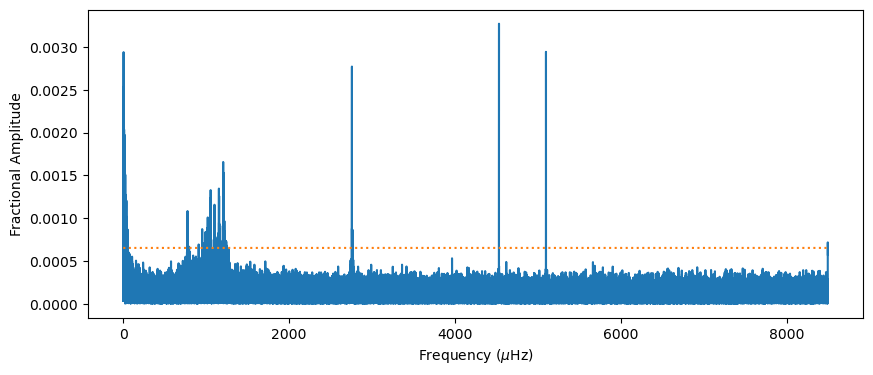

In [14]:
fig = plt.figure(figsize=(10,4))
ax = fig.subplots(1,1)
ax.plot(freq,FT_amp)
ax.plot(freq,FT_thresh + 0.*FT_amp,':')
ax.set_xlabel('Frequency ($\mu$Hz)')
ax.set_ylabel('Fractional Amplitude')

In [19]:

def make_plot (filename) :
    var = np.loadtxt (filename)
    time = var[:,0]
    flux = var[:, 1]
    freq, FT_amp = ls(time, flux)
    df = np.median(np.diff(freq) )
    print(df)

    f_grid = np.arange (0, 8000.015, 0.1)
    print(f_grid)

    f = interp1d(freq, FT_amp, fill_value="extrapolate")
    ft_grid = f(f_grid)
    print(ft_grid)

    fig = plt.figure(figsize= (10,4))
    ax = fig.subplots (1,1)
    ax.plot(freq, FT_amp)
    ax.set_xlabel( 'Frequency ($\mu$Hz) ')
    ax.set_ylabel( 'Fractional Amplitude')

    # save txt of the data
    # FT_data = np. column_stack( (freq, FT_amp) )
    FT_data = np. column_stack((f_grid, ft_grid))
    np.savetxt(filename.replace('lc1', 'txt'), FT_data, fmt='%.6e')

    # save pdf of the plot
    plt.savefig (filename. replace('lcl', 'pdf'))

0.014006677418365143
[0.0000e+00 1.0000e-01 2.0000e-01 ... 7.9998e+03 7.9999e+03 8.0000e+03]
[-1.16306189e-04 -8.23594676e-06  1.00479205e-04 ...  8.21343749e-05
  1.52433471e-04  7.46928622e-05]


ValueError: Format 'lc1' is not supported (supported formats: eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff, webp)

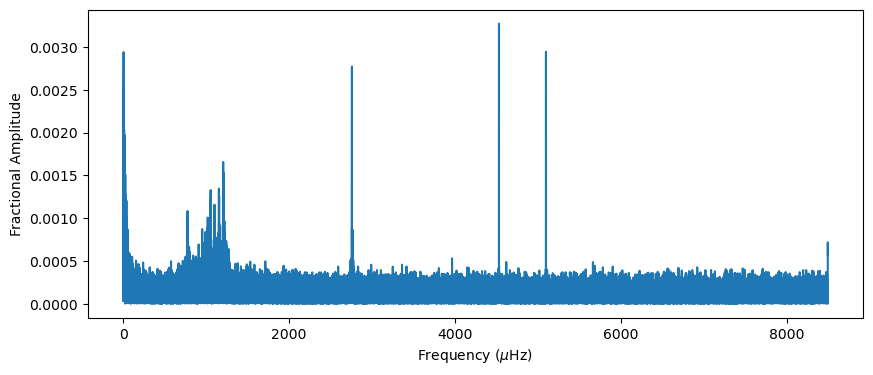

In [20]:
make_plot('kplr004552982.lc1')

In [16]:
import glob
files = glob.glob ('*. lc1')
files

[]

In [21]:
"""
This notebook will output two files:
- source_ids+coords.csv, which has three columns (Gaia DR3 Source ID, RA, Dec)
- UMAP_FILELABEL.csv, which has the X and Y coordinates for the t-SNE plot
"""
#!pip install umap

import numpy as np
#import h5py
import matplotlib.pyplot as p
from astropy.io import fits
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline, InterpolatedUnivariateSpline
from scipy.stats import sigmaclip
import pandas as pd
#from startup import *
from astropy.table import Table
import umap.umap_ as umap
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.table import join_skycoord
from gaiaxpy.calibrator.calibrator import _generate_xp_matrices_and_merge

In [23]:
# D = Table.read('/home/mk43259/Gaia_WDs/Gentile_WD21_BPRPspec.fits')
D = Table.read('Gentile_WD21_BPRPspec.fits')
D = D[np.where((D['Pwd'] > 0.9)&(D['phot_g_mean_mag'] <21))[0]]

In [24]:
#Normalize the bp and rp coefficients by the mean g flux
from sklearn.preprocessing import StandardScaler

spectra = []
for i in range(len(D)):
    spectra.append(np.hstack([D['bp_coefficients'][i]/D['phot_g_mean_flux'][i],\
                           D['rp_coefficients'][i]/D['phot_g_mean_flux'][i]]))
spectra = np.array(spectra)

In [25]:
spectra = np.array(spectra)  # normalized by the mean g flux
print(np.shape(spectra))

(97530, 110)


In [26]:
reducer = umap.UMAP(n_neighbors=50, min_dist = 0.05)
embedding = reducer.fit_transform(spectra)
embedding.shape

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


(97530, 2)

Text(0.5, 1.0, 'coeff normed by G flux')

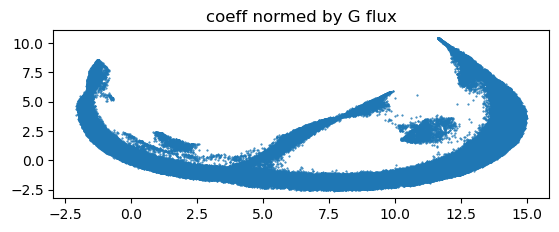

In [27]:
p.close('all')
p.figure()
ax1=p.subplot(2,1,1)
p.plot(embedding[:,0],embedding[:,1],'.',ms=1)
ax1.set_title('coeff normed by G flux')